In [1]:
import trimesh
import numpy as np


In [2]:
# 转成 stl 之后可以
mesh = trimesh.load_mesh("cantilever.stl")

In [3]:
mesh.centroid.copy()[0] = 1

<IPython.core.display.Javascript object>


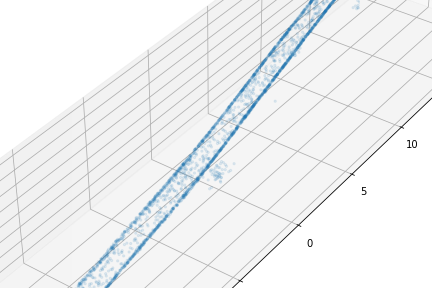

In [23]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#定义图像和三维格式坐标轴
fig=plt.figure()
ax = Axes3D(fig)
x, y, z = np.array(mesh.vertices)[:, 0], np.array(mesh.vertices)[:, 1], np.array(mesh.vertices)[:, 2]
x = x[::100]
y = y[::100]
z = z[::100]

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([5, 1, 1, 1]))

ax.scatter(x, y, z, alpha=0.1, s=5)

In [19]:
%matplotlib notebook
%matplotlib inline

In [75]:
sfb = SkeletonForBeam(mesh, [1, 0, 0])
sfb.getIntersections()

In [71]:
sfb.Intersections

[]

In [76]:
sfb.getCentroids()

In [77]:
sfb.Centroids

[array([-21.19874553,  -0.92469855,  -5.50272865]),
 array([-20.19874553,  -0.94606902,  -5.54301441]),
 array([-19.19874553,  -0.91224905,  -5.54710818]),
 array([-18.19874553,  -0.87639665,  -5.55017508]),
 array([-17.19874553,  -0.84093035,  -5.55418507]),
 array([-16.19874553,  -0.80121541,  -5.55151074]),
 array([-15.19874553,  -0.76793399,  -5.55119343]),
 array([-14.19874553,  -0.73246069,  -5.55472407]),
 array([-13.19874553,  -0.69134811,  -5.55732384]),
 array([-12.19874553,  -0.64936617,  -5.5445034 ]),
 array([-11.19874553,  -0.60910341,  -5.53520048]),
 array([-10.19874553,  -0.56822537,  -5.52681111]),
 array([-9.19874553, -0.52811914, -5.51537145]),
 array([-8.19874553, -0.48529163, -5.50875926]),
 array([-7.19874553, -0.43941818, -5.50185558]),
 array([-6.19874553, -0.3941297 , -5.49253697]),
 array([-5.19874553, -0.35062001, -5.48432812]),
 array([-4.19874553, -0.30128519, -5.47523299]),
 array([-3.19874553, -0.25256632, -5.4734453 ]),
 array([-2.19874553, -0.20042308,

<IPython.core.display.Javascript object>


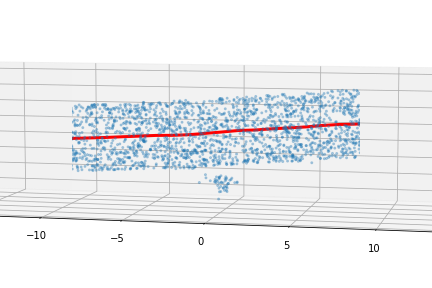

In [83]:
fig=plt.figure()
ax = Axes3D(fig)
x, y, z = np.array(mesh.vertices)[:, 0], np.array(mesh.vertices)[:, 1], np.array(mesh.vertices)[:, 2]
x = x[::100]
y = y[::100]
z = z[::100]

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([4, 1, 1, 1]))
ax.scatter(x, y, z, alpha=0.3, s=4)
sx, sy, sz = sfb.returnXYZOfCentroids()
ax.plot(sx, sy, sz, color='red', linewidth=3)

In [53]:
slice = mesh.section(plane_origin=mesh.centroid, 
                 plane_normal=np.array([1, 0, 0]))
slice_2D, to_3D = slice.to_planar()
slice_firstPart = slice_2D.split()[0] # 分割，并选取第一个部分（应该是最大的那个部分）

In [54]:
slice_firstPart.to_3D(to_3D).centroid

array([-0.91451625, -0.13691134, -5.44386294])

In [39]:
slice_2D.sp

AttributeError: 'Path3D' object has no attribute 'split'

In [5]:
def getXYLengthOfIntersection(plane_origin, plane_normal):
    slice = mesh.section(plane_origin=mesh.centroid, 
                     plane_normal=plane_normal)
    slice_2D, to_3D = slice.to_planar()
    slice_firstPart = slice_2D.split()[0] # 分割，并选取第一个部分（可能是最大的那个部分）
    slice_firstPart.apply_obb() # 旋转
    xL = slice_firstPart.bounds[1][0] - slice_firstPart.bounds[0][0]
    yL = slice_firstPart.bounds[1][1] - slice_firstPart.bounds[0][1]
    return [xL, yL]

In [6]:
def getAreaOfIntersection(plane_origin, plane_normal):
    slice = mesh.section(plane_origin=mesh.centroid, 
                     plane_normal=plane_normal)
    slice_2D, to_3D = slice.to_planar()
    slice_firstPart = slice_2D.split()[0] # 分割，并选取第一个部分（应该是最大的那个部分）
    return slice_firstPart.area

In [7]:
def getNormalVector():
    vecList = []
    rangeX = np.arange(0.01, 0.06001, 0.01)
    rangeY = [0]
    for i in range(len(rangeX)):
        x = rangeX[i]
        for j in range(len(rangeY)):
            y = rangeY[j]
            vecList.append([np.sqrt(1 - x**2 - y**2), x, y])
    return vecList

In [16]:
def getAreaOfIntersection2(z_levels, plane_normal):
    sections = mesh.section_multiplane(plane_origin=mesh.centroid, 
                                       plane_normal=plane_normal,
                                       heights=z_levels)
    sections = [i for i in sections if i is not None]
    As = [i.area for i in sections]
    return sum(As)

In [ ]:
slice = mesh.section(plane_origin=mesh.centroid, 
                 plane_normal=np.array([1, 0, 0]))
slice_2D, to_3D = slice.to_planar()
slice_firstPart = slice_2D.split()[0] # 分割，并选取第一个部分（应该是最大的那个部分）

In [74]:
class SkeletonForBeam:
    Intersections = None
    Centroids = None
    
    def __init__(self, mesh, rough_normalVector):
        self.mesh = mesh
        self.centroid = mesh.centroid.copy()
        # 质心截面的一个大致的法向量（目前只支持 [1, 0, 0]）
        self.nVec = rough_normalVector
        
          
    def getIntersections(self):
        sections = []
        # 沿着法向量截面
        extents = mesh.bounds[:, 0] # 截取区间
        levels = np.arange(*extents, step=1)  # 每隔 1m 截一次
        for i in range(len(levels)):
            origin_temp = self.centroid.copy()
            origin_temp[0] = origin_temp[0] + levels[i]
            try:
                slice = self.mesh.section(plane_origin=origin_temp,  plane_normal=self.nVec)
                if slice is not None:
                    slice_2D, to_3D = slice.to_planar()
                    slices_splited = slice_2D.split()
                    sliceIndex = np.argmax([s.area for s in slices_splited])
                    slice_2D = slices_splited[sliceIndex]
                    sections.append(slice_2D.to_3D(to_3D))
            except:
                pass
        
        self.Intersections = sections
        '''
        sections = [i for i in sections if i is not None]
                                            
        for i in range(len(sections)):
            slices_splited = sections[i].split()
            sliceIndex = np.argmax([s.area for s in slices_splited])
            sections[i] = slices_splited[sliceIndex] 
            
        self.secHeights = [levels[i] for i in heightIndex]
        self.Intersections = sections
        '''
        
                
    def getCentroids(self):        
        self.Centroids = []
        for s in self.Intersections:
            self.Centroids.append(s.centroid)    
    
            
    def returnXYZOfCentroids(self):
        return np.array(self.Centroids)[:, 0], np.array(self.Centroids)[:, 1], np.array(self.Centroids)[:, 2]
        
        

In [66]:
a = np.array([0, 0]) .+ np.array([1, 2, 3])


SyntaxError: invalid syntax (<ipython-input-66-c63ddf5e56e5>, line 1)

In [128]:
nVs = getNormalVector()

In [129]:
z_extents = mesh.bounds[:,0]
z_levels  = np.arange(*z_extents, step=2)

lis = []
lisIndex = []
p = mesh.centroid
for i in range(len(nVs)):
    try:
        A = getAreaOfIntersection2(z_levels, nVs[i])
        if A > 1e-3:
            lis.append(A)
            lisIndex.append(i)
    except:
        pass

In [63]:

np.argsort([7, 9, 8])[0]

0

 得出  [0.998749217771909, 0.04999999999999995, -4.163336342344337e-17] 表现较好

In [94]:
z_extents = mesh.bounds[:,0]
# slice every .125 model units (eg, inches)
z_levels  = np.arange(*z_extents, step=2)

lis = []
lisIndex = []
p = mesh.centroid
for i in range(len(nVs)):
    try:
        A = getAreaOfIntersection2(z_levels, nVs[i])
        if A > 1e-3:
            lis.append(A)
            lisIndex.append(i)
    except:
        pass

In [95]:
LL = np.array(lis)
np.argsort(LL)

array([84, 75, 66, 57, 48, 39, 83, 74, 30, 65, 58, 21, 67, 49, 40, 76, 56,
       31, 22, 85, 13, 12,  4, 47,  3, 38, 29, 20, 11,  2, 59, 50, 14, 41,
       68, 23, 32,  5, 77, 86, 60, 51, 69, 42, 33, 24, 15,  6, 78, 87, 46,
       37, 55, 28, 64, 19, 73, 10, 82,  1, 52, 43, 34, 61, 25, 70, 16, 79,
        7, 88, 72, 63, 81, 54, 45, 36, 27, 18,  9,  0, 62, 71, 80, 35, 44,
       26, 53, 89, 17,  8], dtype=int64)

In [217]:
lis = []
lisIndex = []
p = mesh.centroid
for i in range(len(nVs)):
    try:
        lis.append(getXYLengthOfIntersection(p, nVs[i]))
        lisIndex.append(i)
    except:
        pass

In [218]:
LL = np.array(lis)

In [219]:
np.argsort(LL[:, 0])

array([109,  59,  60,  57,  58,  56, 116, 115, 119,  10, 118, 108,   9,
       117,   8, 107,  21,   7, 114,   6, 106,   0,  97, 113,   1,   5,
        20,   4, 112,   3,   2, 111, 110, 105,  19, 104,  96,  18, 103,
        11,  17, 102,  32,  16,  12,  95,  15, 101,  13,  14, 100,  98,
        99,  94,  86,  31,  93,  30,  92,  29,  85,  22,  91,  28,  23,
        27,  90,  24,  25,  26,  89,  88,  87,  84,  83,  43,  82,  42,
        81,  41,  33,  75,  80,  34,  40,  35,  79,  36,  39,  38,  37,
        78,  77,  76,  74,  73,  72,  71,  70,  44,  45,  69,  46,  54,
        68,  47,  48,  53,  67,  49,  50,  52,  51,  66,  65,  64,  63,
        62,  61,  55], dtype=int64)

In [220]:
np.argsort(LL[:, 1])

array([ 59, 109,  57,  56,  60,  58, 116, 115,  87,   0, 110,  11,  76,
        98,  22,  88,   1,  99, 111,  33,  12,  77,  23, 100,  44,  65,
        34,   2,  78,  13,  89,  66,  45, 112,  24, 101,   3,  90,  67,
        35,  46,  79, 113,  14,  25,  68,   4,  36,  47,  91, 102, 114,
        15,  26, 103,  80,  69,   5,  37,  92,  48,  16,  81, 104,  27,
        38,  70,  49,   6,  93,  82,  17,  28, 105,  39,  71, 117,   7,
        50,  94,  18,  83, 106,  29,   8,  72,  40,  55, 118,  95,  51,
        19, 119,  84, 107,   9,  30,  73,  41,  52,  96, 108,  20,  10,
        85,  31,  74,  62,  97,  42,  61,  21,  53,  63,  86,  32,  43,
        75,  54,  64], dtype=int64)

In [223]:
nVs[lisIndex[109]]

[0.4999999999999998, -0.5, 0.7071067811865477]

In [13]:
lis = []
lisIndex = []
p = mesh.centroid
for i in range(len(nVs)):
    try:
        A = getAreaOfIntersection(p, nVs[i])
        if A > 1e-3:
            lis.append(A)
            lisIndex.append(i)
    except:
        pass

In [14]:
LL = np.array(lis)

In [15]:
np.argsort(LL)

array([190, 206, 207, 191, 208, 192, 175, 189, 223, 205, 209, 222, 224,
       176, 174, 193, 210, 226, 225, 227, 188, 204, 177, 228, 221, 194,
       158, 173, 229, 157, 246, 244, 240, 245, 241, 243, 159, 220, 242,
       187, 239, 211, 203, 247, 160, 156, 172, 238, 195, 230, 178, 141,
       140, 161, 219, 237, 263, 212, 264, 142, 257, 262, 155, 248, 258,
       256, 139, 196, 261, 186, 265, 143, 179, 236, 171, 255, 259, 123,
       162, 260, 213, 124, 202, 231, 138, 254, 218, 122, 180, 144, 125,
       274, 281, 163, 273, 154, 272, 282, 164, 275, 280, 235, 271, 253,
       185, 276, 121, 197, 170, 277, 165, 106, 137, 145, 126, 270, 279,
       201, 217, 107, 214, 105, 278, 147, 146, 252, 148, 153, 181, 234,
       104, 108, 269, 127, 166, 120, 198, 251, 136, 130, 128,  89, 169,
       129, 131,  88, 200, 149, 184, 216,  90, 109, 152, 182,  87, 103,
       268, 119, 233, 167, 110, 112, 132, 113, 111,  91, 135, 250,  72,
       150,  71,  86, 168, 114,  92,  70, 102, 199, 267, 118, 15

In [297]:
LL[190]

0.2363395960066506

In [235]:
v = nVs[lisIndex[58]]
v

[-1.1102230246251565e-16, -0.20000000000000007, 0.9797958971132712]

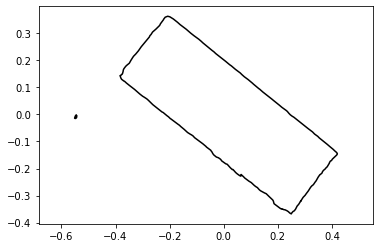

In [19]:
# get a single cross section of the mesh
slice = mesh.section(plane_origin=mesh.centroid, 
                     plane_normal=[1,0, 0])
slice_2D, to_3D = slice.to_planar()
slice_2D.show()

In [27]:
slice_2D.to_3D(to_3D)

In [24]:
dict(slice_2D.to_dict())

{'entities': [{'type': 'Line',
   'points': [0,
    163,
    219,
    22,
    351,
    252,
    148,
    30,
    227,
    257,
    48,
    241,
    352,
    282,
    156,
    144,
    92,
    121,
    52,
    176,
    329,
    350,
    331,
    303,
    183,
    108,
    190,
    62,
    122,
    161,
    232,
    64,
    346,
    268,
    113,
    33,
    70,
    115,
    134,
    194,
    272,
    269,
    274,
    6,
    306,
    255,
    130,
    102,
    320,
    181,
    46,
    226,
    19,
    307,
    91,
    262,
    170,
    61,
    347,
    65,
    259,
    105,
    233,
    159,
    333,
    97,
    318,
    73,
    123,
    322,
    202,
    60,
    142,
    114,
    281,
    330,
    109,
    337,
    40,
    357,
    229,
    75,
    198,
    218,
    71,
    344,
    186,
    182,
    336,
    299,
    28,
    67,
    7,
    117,
    270,
    249,
    250,
    32,
    128,
    94,
    15,
    319,
    298,
    184,
    103,
    112,
    152,
    223,
    327,
    216,


In [3]:
pc = trimesh.PointCloud(np.array([[1, 2, 3], [2, 3, 4], [2, 3, 4], [2.1, 3, 4], [2.2, 3, 4], [2.3, 3, 4]]))
pc.scene()

<trimesh.Scene(len(geometry)=1)>

In [5]:
trimesh.viewer.SceneViewer()

AttributeError: module 'trimesh' has no attribute 'viewer'

In [6]:
from trimesh import viewer

In [10]:
viewer.notebook.scene_to_notebook(pc.scene())

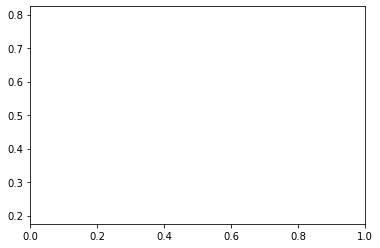

In [18]:
trimesh.path.Path2D(vertices=np.array([[0.2, 0.5], [0.2, 0.6], [2, 3], [2.1, 3], [2.2, 3], [2.3, 3]])).show()

In [88]:
slice_2D.centroid

array([-0.06559599, -0.00230259])

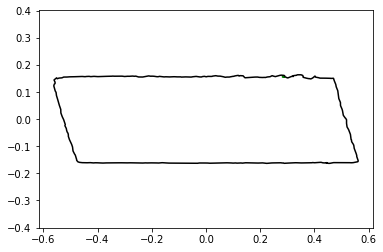

In [31]:
index = np.argmax([i.area for i in slice_2D.split()])
slice_firstPart = slice_2D.split()[index] # 分割，并选取第一个部分（可能是最大的那个部分）
slice_firstPart.apply_obb() # 旋转
slice_firstPart.show()

In [239]:
slice_firstPart.area

0.23687650187814532

In [89]:

v = np.array([0, 0, 190])
# get a single cross section of the mesh
slice = mesh.section(plane_origin=mesh.centroid, 
                     plane_normal=v)
slice_2D, to_3D = slice.to_planar()
slice_2D.show()

NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.

In [21]:
slice_firstPart.area

2.6518802743932962e-06

In [304]:
slice_firstPart.area

0.23633959600665042

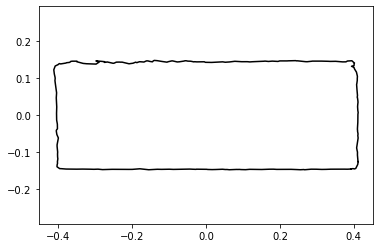

In [305]:
slice_firstPart.show()

In [291]:
v

[1.0, -1.1102230246251565e-16, -1.1102230246251565e-16]

In [290]:
slice_2D.area

0.23693800032775691

In [ ]:
# get a single cross section of the mesh
slice = mesh.section(plane_origin=mesh.centroid, 
                     plane_normal=[0,0,1])

In [60]:
mesh.bounds

array([[-21.28422928,  -1.49518299,  -6.24997091],
       [ 18.52413559,   1.31816697,  -4.69799995]])

In [47]:
pts = np.array(mesh.vertices)

In [51]:
pts_m = pts - mesh.centroid

In [56]:
np.argmin(np.sum(pts_m**2, axis=1))

18298

In [61]:
pts1 = np.array(sorted(pts_m, key=lambda x:np.sum(x**2)))
pts1

array([[-2.32972639e-03,  8.16096653e-02,  5.93253628e-02],
       [-1.57947733e-02,  7.48306652e-02,  6.62790791e-02],
       [-3.56074112e-03,  7.31146651e-02,  6.99092403e-02],
       ...,
       [-2.03681795e+01, -8.20351313e-01, -3.91489838e-01],
       [-2.03643992e+01, -9.77227341e-01,  1.90343048e-01],
       [-2.03662264e+01, -9.58352338e-01,  1.70305397e-01]])

In [63]:
pts2 = pts1 - pts1[0]
pts2

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.34650469e-02, -6.77900016e-03,  6.95371628e-03],
       [-1.23101473e-03, -8.49500019e-03,  1.05838776e-02],
       ...,
       [-2.03658498e+01, -9.01960978e-01, -4.50815201e-01],
       [-2.03620694e+01, -1.05883701e+00,  1.31017685e-01],
       [-2.03638967e+01, -1.03996200e+00,  1.10980034e-01]])

In [35]:
vertices = np.array(mesh.vertices)
zcor = [vertices[i][2] for i in range(len(vertices))]
len(zcor)

464258

In [33]:
def segmentPoints(points, segN):
    pointsIndex = []
    zposes = [points[i][2] for i in range(len(points))]
    zmax = max(zposes)
    zmin = min(zposes)
    segLen = (zmax - zmin - 0.001) / segN
    print(segLen)
    for i in range(segN):
        zleft = (zmin + i*segLen)*0.999
        zright = (zmin + i*segLen)*1.001
        print(1)
        for j in range(len(zposes)):
            if zposes[j] < zright and zposes[j] > zleft:
                pointsIndex.append(j)
                break
    return pointsIndex

In [84]:
slice = mesh.section(plane_origin=mesh.centroid, 
                     plane_normal=[1,0,0])

In [87]:
# we can move the 3D curve to a Path2D object easily
slice_2D, to_3D = slice.to_planar()
slice_2D.show()

NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.

In [110]:
G = trimesh.grouping.clusters(mesh.vertices, 0.2)
len(G)

6

In [116]:
newV = [mesh.vertices[i] for i in G[0]]

In [117]:
pc = trimesh.points.PointCloud(newV)

In [118]:
pc.

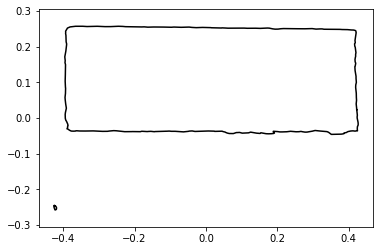

In [106]:
slice_2D.show()

In [105]:
slice_2D.apply_obb()

array([[ 1.,  0.,  0.],
       [-0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [96]:
z_extents = mesh.bounds[:,0]
# slice every .125 model units (eg, inches)
z_levels  = np.arange(*z_extents, step=2)

In [135]:
nVs[11]

[0.998749217771909, 0.05000000000000002, 0]

In [138]:
source = np.array([0.998749217771909, 0.05000000000000002, 0])

In [139]:
v = []
for i in np.arange(-0.01, 0.01001, 0.003):
    for j in np.arange(-0.01, 0.01001, 0.003):
        v.append(source + np.array([0, i, j]))

In [142]:
len(v)

49

In [148]:
v[4]

array([0.99874922, 0.04      , 0.002     ])

In [157]:
v[12]

array([0.99874922, 0.043     , 0.005     ])

In [159]:
v[27]

array([0.99874922, 0.049     , 0.008     ])

In [168]:
v2 =[]
s2 = np.array([0.99874922, 0.049     , 0.008     ])
for i in np.arange(-0.004, 0.004001, 0.001):
    for j in np.arange(-0.004, 0.004001, 0.001):
        v2.append(s2 + np.array([0, i, j]))

In [169]:
len(v2)

81

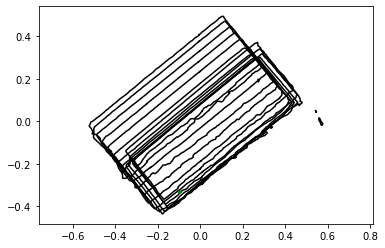

0


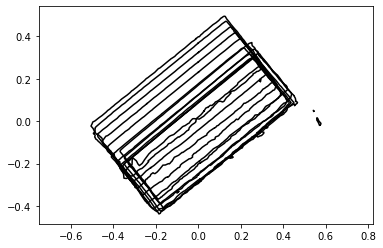

1


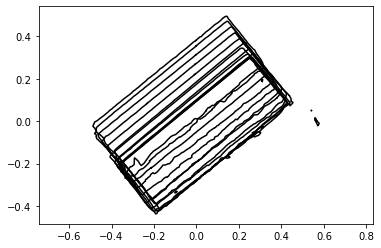

2


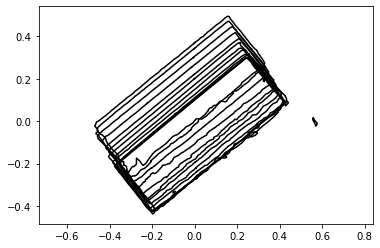

3


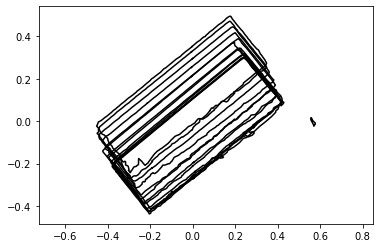

4


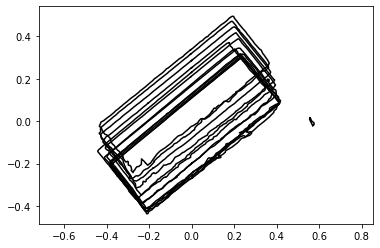

5


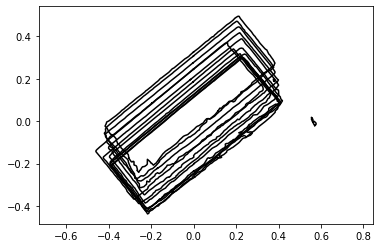

6


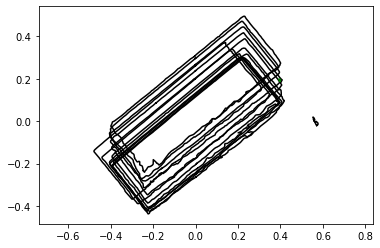

7


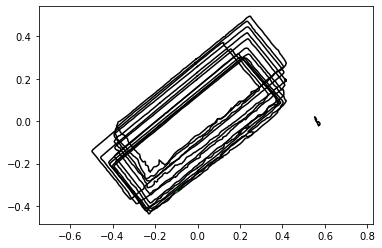

8


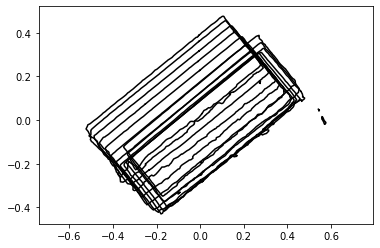

9


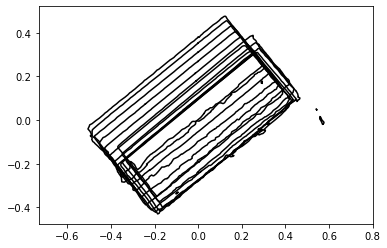

10


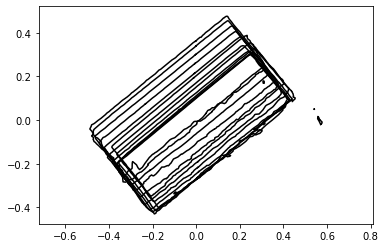

11


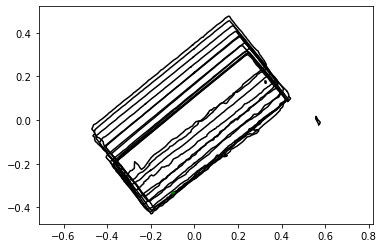

12


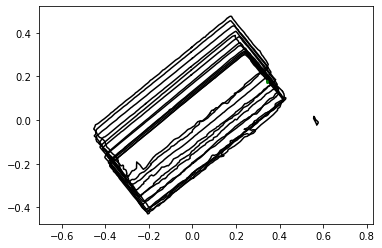

13


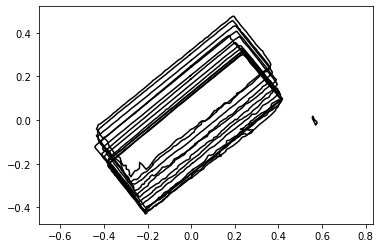

14


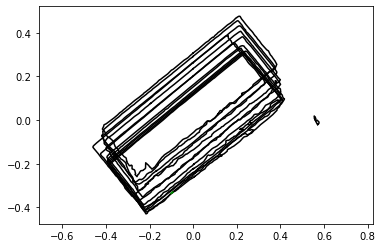

15


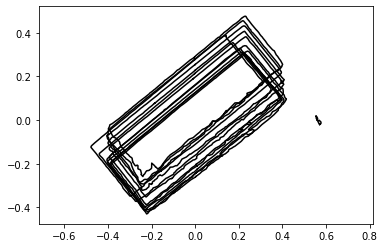

16


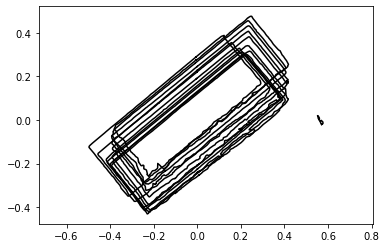

17


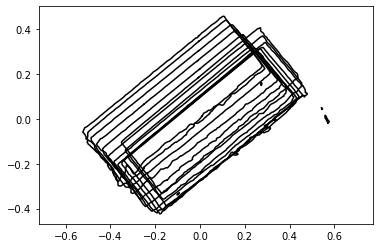

18


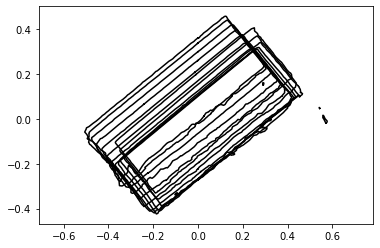

19


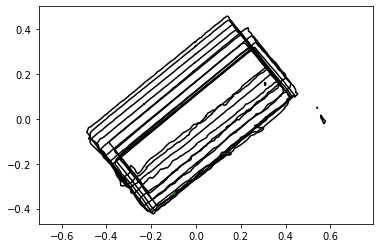

20


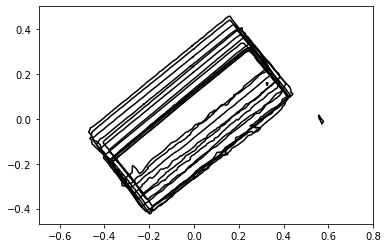

21


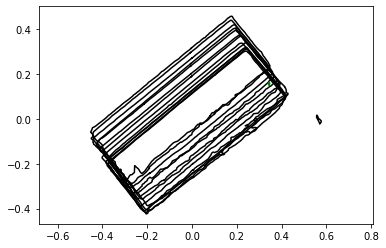

22


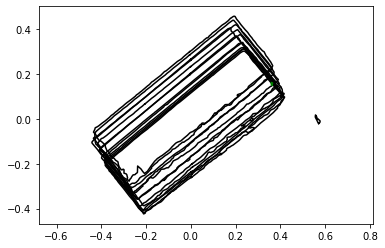

23


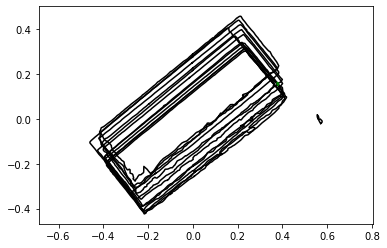

24


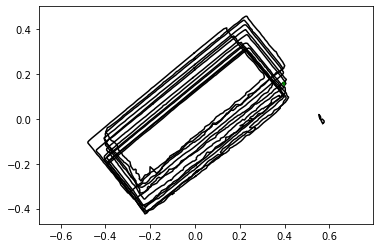

25


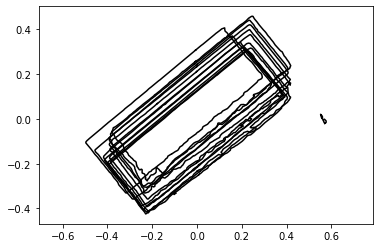

26


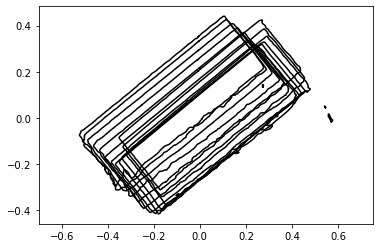

27


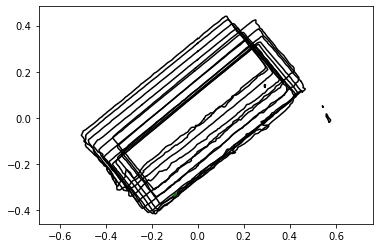

28


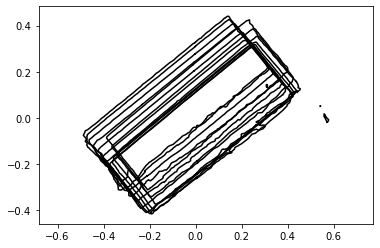

29


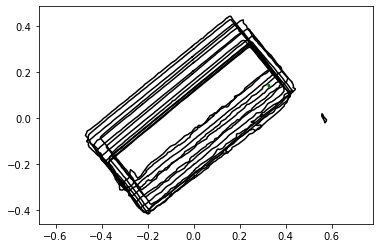

30


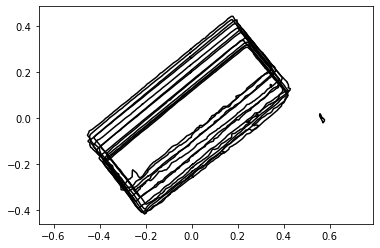

31


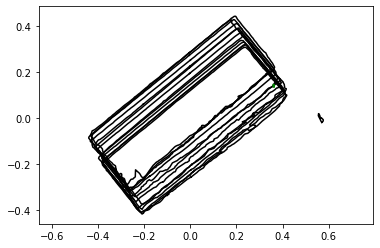

32


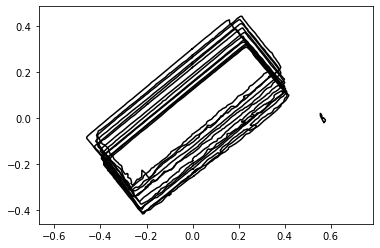

33


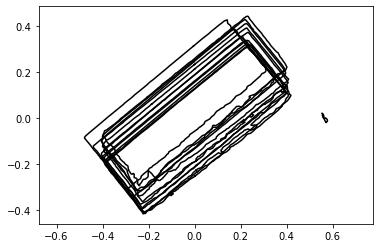

34


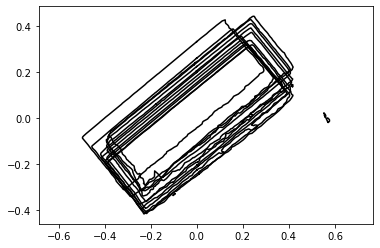

35


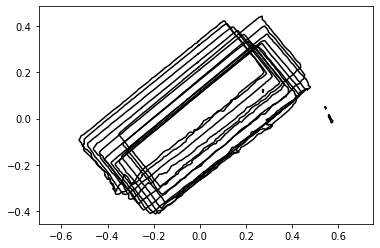

36


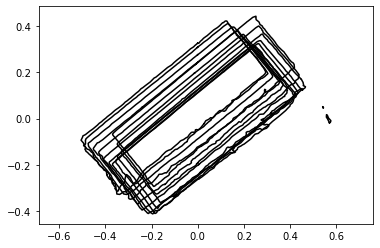

37


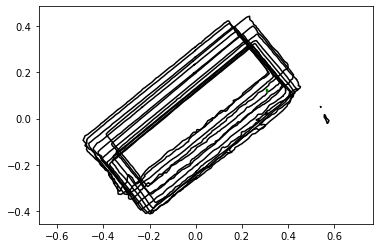

38


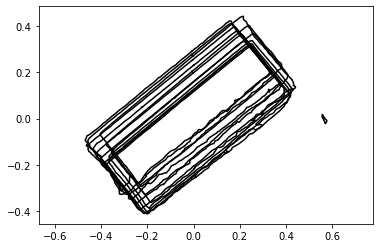

39


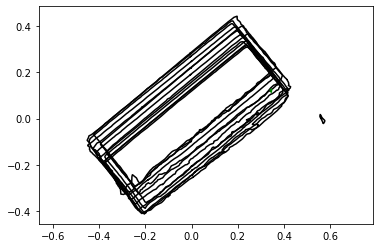

40


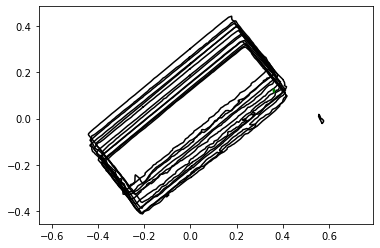

41


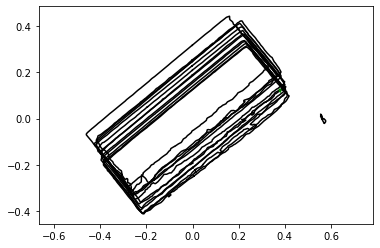

42


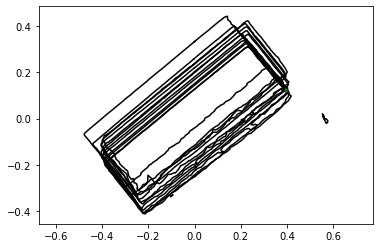

43


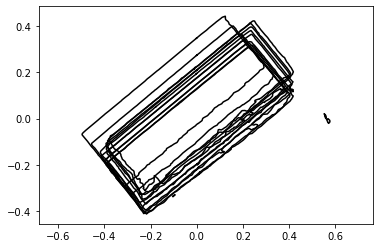

44


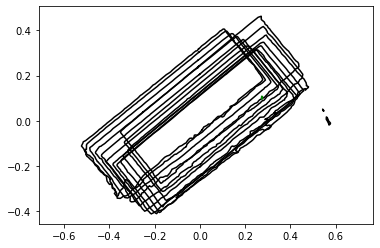

45


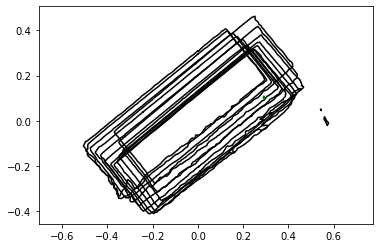

46


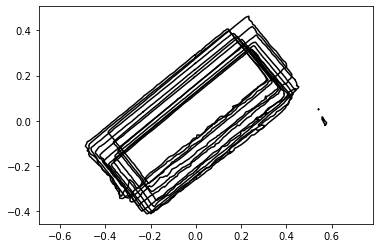

47


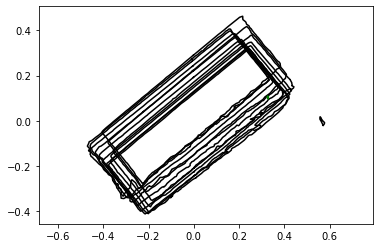

48


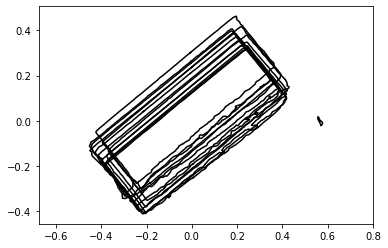

49


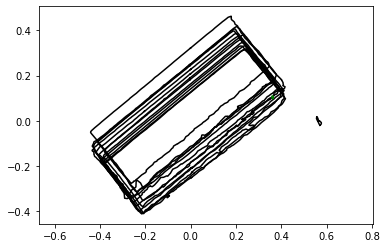

50


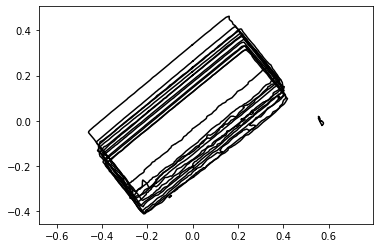

51


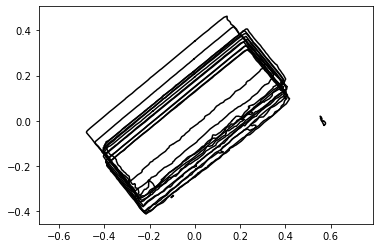

52


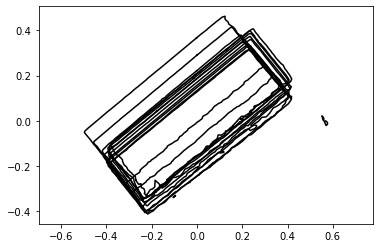

53


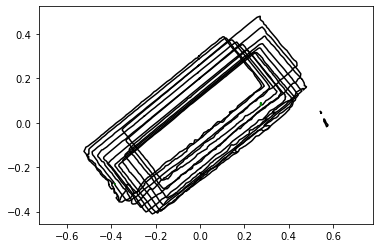

54


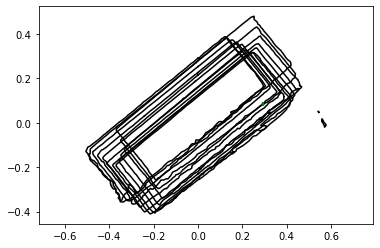

55


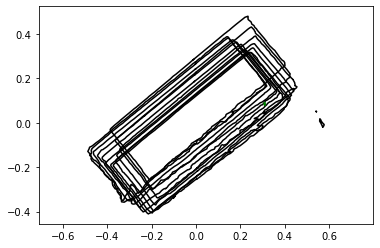

56


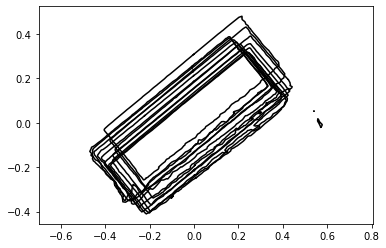

57


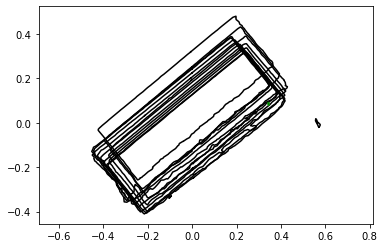

58


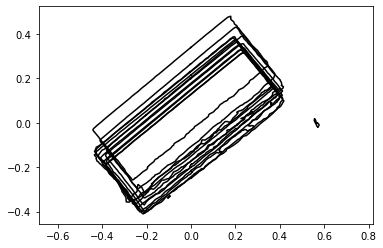

59


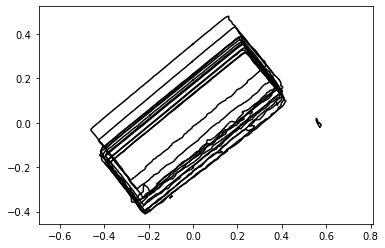

60


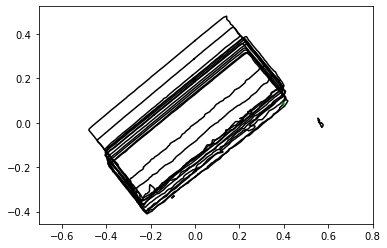

61


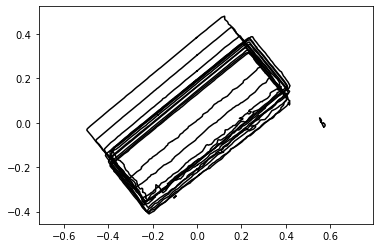

62


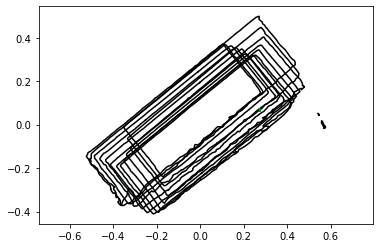

63


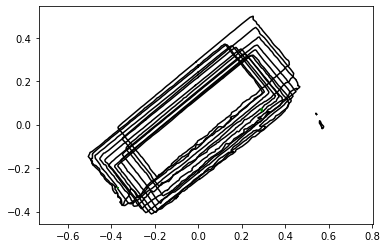

64


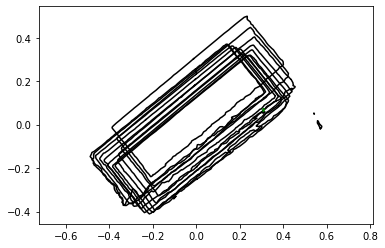

65


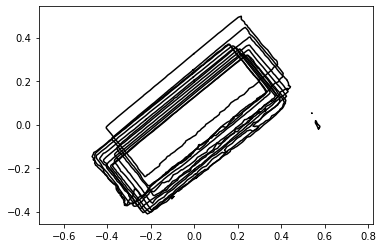

66


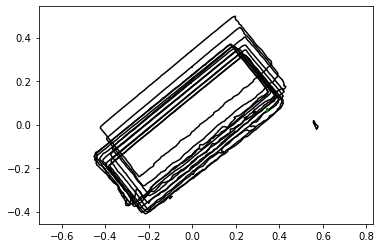

67


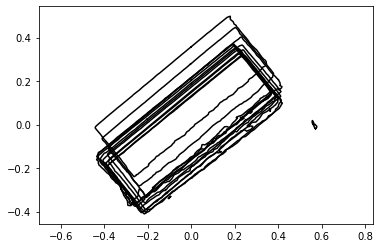

68


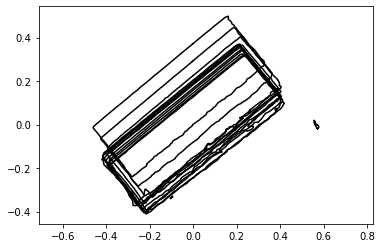

69


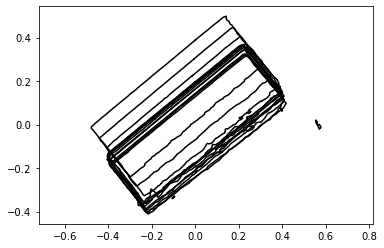

70


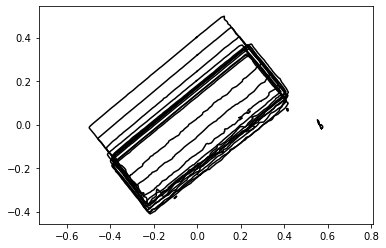

71


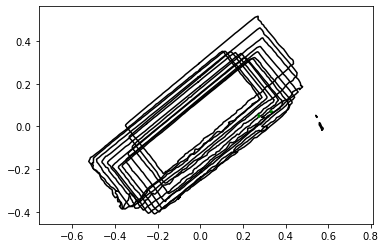

72


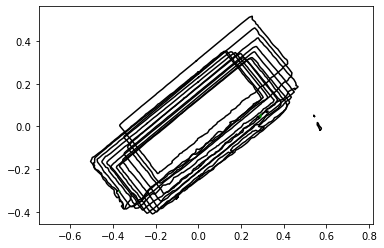

73


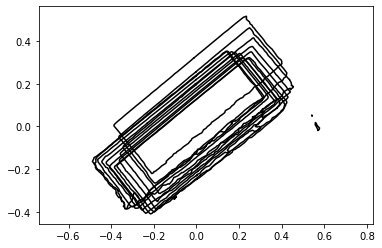

74


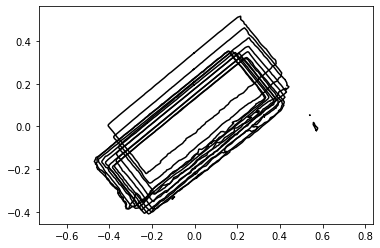

75


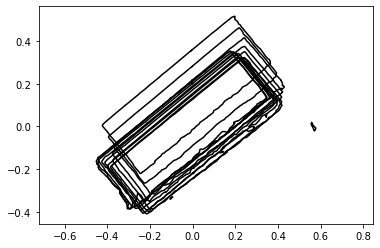

76


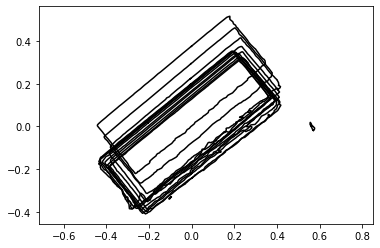

77


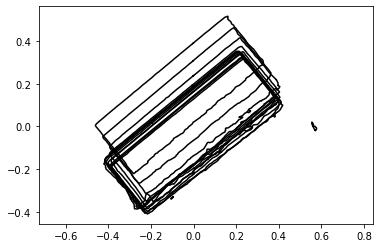

78


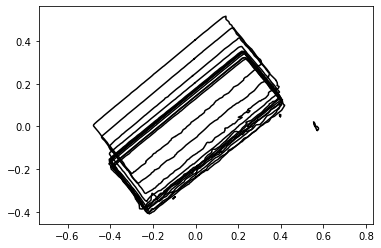

79


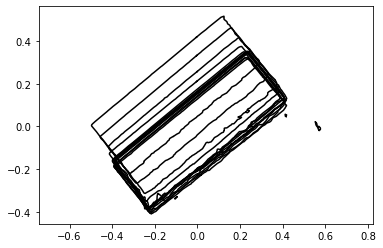

80


In [170]:
z_extents = mesh.bounds[:,0]
# slice every .125 model units (eg, inches)
z_levels  = np.arange(*z_extents, step=3)

for i in range(81):
    sections = mesh.section_multiplane(plane_origin=mesh.centroid, 
                                       plane_normal=v2[i],
                                       heights=z_levels)

    sections = [i for i in sections if i is not None]
    combined = np.sum(sections)
    combined.show()
    print(i)

In [171]:
v2[80]

array([0.99874922, 0.053     , 0.012     ])

In [174]:
v2[60]

array([0.99874922, 0.051     , 0.01      ])

In [176]:
for i in [67, 68, 69, 70, 71]:
    print(v2[i])

[0.99874922 0.052      0.008     ]
[0.99874922 0.052      0.009     ]
[0.99874922 0.052      0.01      ]
[0.99874922 0.052      0.011     ]
[0.99874922 0.052      0.012     ]


In [101]:
v =np.array([0.99874922, 0.01     , 0.01    ])

z_extents = mesh.bounds[:,0]
# slice every .125 model units (eg, inches)
z_levels  = np.arange(*z_extents, step=2)
sections = mesh.section_multiplane(plane_origin=mesh.centroid, 
                                   plane_normal=v,
                                   heights=z_levels)

sections = [i for i in sections if i is not None]

In [102]:
for i in sections:
    print(i.centroid)

[-0.0808187  -0.68415797]
[-0.05244209 -0.61441128]
[-0.03162751 -0.55959312]
[-0.00761845 -0.51062245]
[ 0.00163905 -0.44857006]
[ 0.00434952 -0.38641608]
[ 0.0059985  -0.32322466]
[ 0.00963465 -0.2520308 ]
[ 0.0118243  -0.17934354]
[ 0.02234189 -0.09839798]
[ 0.17643018 -0.01440022]
[0.00595796 0.07462224]
[0.0014987  0.17383224]
[-0.00803218  0.26069624]
[-0.00444226  0.35856196]
[-0.01079051  0.44592003]
[-0.01718904  0.52947823]
[-0.02171196  0.61541831]
[-0.01141335  0.70189291]


In [22]:
z_levels

array([-21.28422928, -19.28422928, -17.28422928, -15.28422928,
       -13.28422928, -11.28422928,  -9.28422928,  -7.28422928,
        -5.28422928,  -3.28422928,  -1.28422928,   0.71577072,
         2.71577072,   4.71577072,   6.71577072,   8.71577072,
        10.71577072,  12.71577072,  14.71577072,  16.71577072])

In [18]:
As = [i.split()[0].area for i in sections]

In [19]:
sum(As)

4.423332262554468

In [223]:
v2[80]

array([0.99874922, 0.053     , 0.012     ])

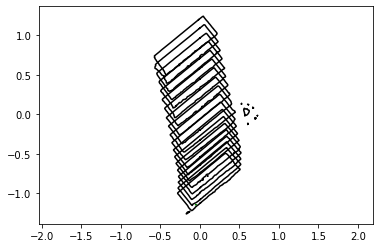

In [20]:
z_extents = mesh.bounds[:,0]
# slice every .125 model units (eg, inches)
z_levels  = np.arange(*z_extents, step=2)
sections = mesh.section_multiplane(plane_origin=mesh.centroid, 
                                   plane_normal=np.array([1, 0, 0]),
                                   heights=z_levels)

sections = [i for i in sections if i is not None]
combined = np.sum(sections)
combined.show()

In [21]:
As = [i.split()[0].area for i in sections]
sum(As)

4.426858859297481

In [103]:
sections = [i for i in sections if i is not None]
As = [i.area for i in sections]
sum(As)

4.431718545553637

In [104]:
1/17

0.058823529411764705

In [89]:
sections[3].area

0.23069609804436214

In [69]:
nVs[190]

[0.9982985525382675, 0.029999999999999943, -0.05000000000000002]

In [91]:
nVs[229]

[0.998749217771909, 0.04999999999999995, -4.163336342344337e-17]

In [101]:
nVs[84]

[0.9984908612501168, 0.054000000000000006, -0.009999999999999995]

In [100]:
for i in [84, 75, 66, 57, 48, 39, 83, 74, 30, 65, 58, 21, 67, 49, 40, 76, 56,
       31, 22, 85, 13, 12,  4, 47,  3, 38, 29, 20, 11,  2, 59, 50, 14, 41]:
    sections = mesh.section_multiplane(plane_origin=mesh.centroid, 
                                   plane_normal=nVs[i],
                                   heights=z_levels)

    sections = [i for i in sections if i is not None]
    As = [i.area for i in sections]
    print(i)
    print(sum(As))

84
4.427406048799741
75
4.4274466441950855
66
4.4274908571827964
57
4.427538348499606
48
4.427586453906525
39
4.427637573681766
83
4.427643148943232
74
4.427676437588944
30
4.427692927032437
65
4.4277189003951
58
4.427747286694833
21
4.427748282125001
67
4.427750930527155
49
4.427751849697686
40
4.427760413781995
76
4.427764793050577
56
4.4277680564583255
31
4.427770509171172
22
4.427779055148074
85
4.427788310204131
13
4.427790831081333
12
4.427803807513306
4
4.427808379517232
47
4.427823707251807
3
4.427861328560951
38
4.4278826621438405
29
4.42792744438282
20
4.4280008961281165
11
4.428077915076081
2
4.428147364799225
59
4.428331182087991
50
4.428331636051145
14
4.428336590420163
41
4.428340365204942


In [ ]:
209

In [ ]:
209
4.429676217656948

